In [ ]:
%pip install 'transformers[torch]' datasets==3.6.0 evaluate wandb numpy wandb -q

#Bypass SSL
!/Applications/Python\ 3.11/Install\ Certificates.command


Note: you may need to restart the kernel to use updated packages.


In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
import evaluate
from torch.utils.data import DataLoader, SequentialSampler
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import wandb

wandb.init(mode="disabled")  # Desabilita o Wandb

max_length= 512
num_labels = 3
batch_size = 28
results_path = "./results"

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from datasets import load_dataset

dataset = load_dataset("hate-speech-portuguese/hate_speech_portuguese")

Using the latest cached version of the dataset since hate-speech-portuguese/hate_speech_portuguese couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/rafael/.cache/huggingface/datasets/hate-speech-portuguese___hate_speech_portuguese/default/1.0.0/20ad7529b5939c566862ef7d6753aa52f92c45aed182decf84abec62c7894062 (last modified on Tue Nov  4 22:14:58 2025).


In [4]:
ds_train_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
test_valid_split = ds_train_split["test"].train_test_split(test_size=0.5, seed=42)


dataset = DatasetDict({
    "train": ds_train_split["train"],
    "test": dataset["train"],
    "val": ds_train_split["test"],
})

train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['val']

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 4536
    })
    test: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 5670
    })
    val: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 1134
    })
})


In [5]:
def show_info_dataset(dataset, title):
    # Converter o dataset para um DataFrame do pandas
    df = dataset.to_pandas()

    # Contar as ocorrências na coluna 'label'
    label_counts = df['label'].value_counts()

    # Mapeamento dos labels para nomes
    label_names = {0: 'Negativo', 1: 'Positivo', 2: 'Neutro'}

    # Obter os nomes das labels
    labels = [label_names[label] for label in label_counts.index]

    # Definir as cores para cada label
    colors = ['green', 'red', 'blue']

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, label_counts, color=colors)

    # Adicionar os totais em cima das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

    # Configurar o título e os rótulos dos eixos
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Total')
    plt.show()

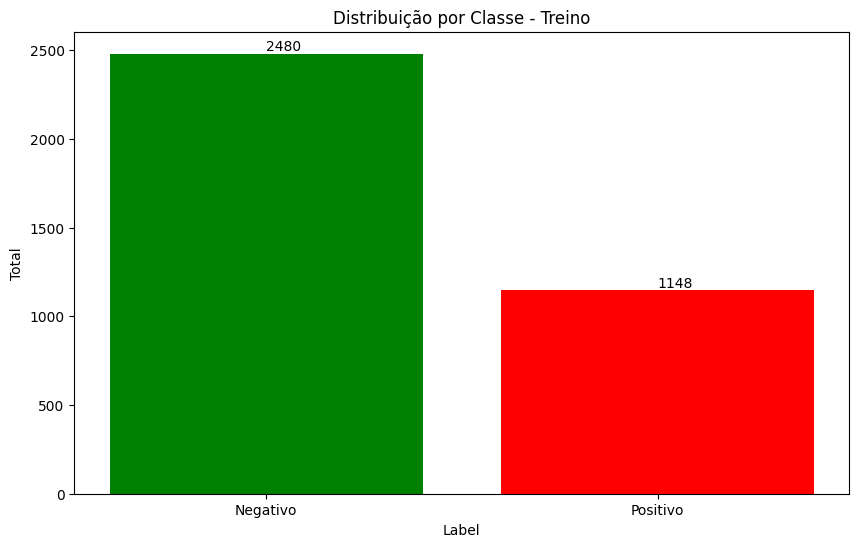

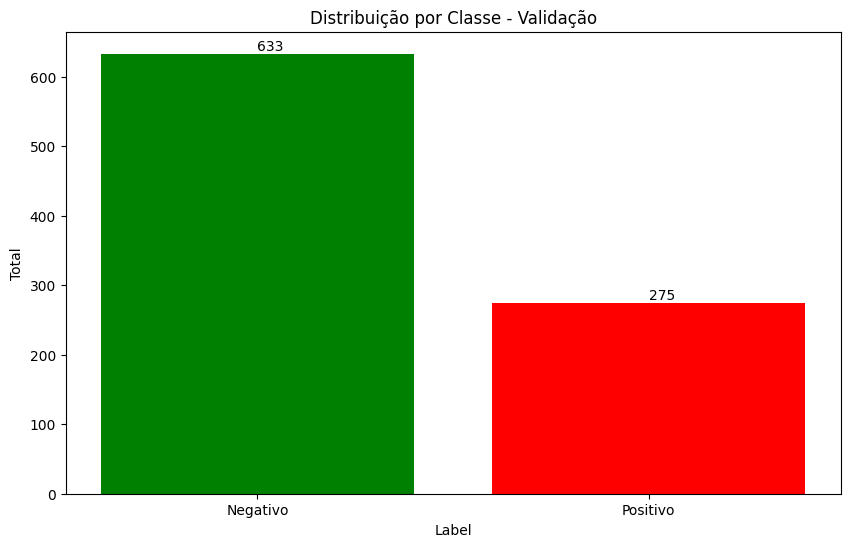

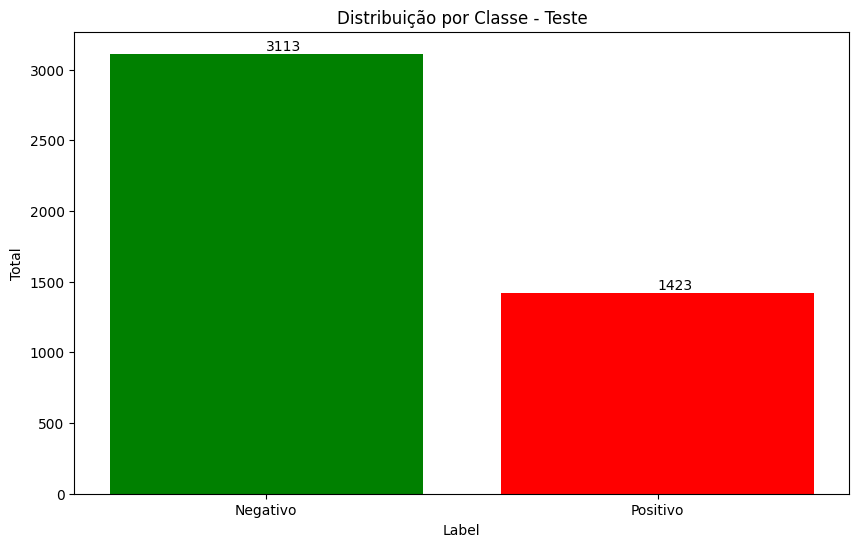

In [7]:
show_info_dataset(train_dataset, 'Distribuição por Classe - Treino')
show_info_dataset(val_dataset, 'Distribuição por Classe - Validação')
show_info_dataset(test_dataset, 'Distribuição por Classe - Teste')

In [1]:
model_id = "neuralmind/bert-large-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_id, do_lower_case=False, revision="main", cache_dir='.cache')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_length)

# Reduz o tamanho dos datasets apenas para conseguir rodar no Google Colab por menos tempo, para rodar com o dataset completo só comentar as próximas 3 linhas
train_dataset = train_dataset.shuffle().select(range(3000))
test_dataset = test_dataset.shuffle().select(range(1000))
val_dataset = test_dataset.shuffle().select(range(800))

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


NameError: name 'BertTokenizer' is not defined